In [1]:
show_plots = True

In [2]:
import os
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame, GeoSeries
from shapely.geometry import Point, Polygon, MultiPolygon, LineString
from shapely.ops import unary_union
import numpy as np
from quetzal.model import stepmodel
import matplotlib.pyplot as plt
from datetime import datetime
import math


SQLalchemy is not installed. No support for SQL output.


In [3]:
# Load the model with LoS tables from the last exercise
input_path = './../../input/'
model_path = '../../model/'
sm = stepmodel.read_json(model_path + 'los_tables')

In [4]:
# check for broken GeoDataFrames
broken_gdf_keys = [key for key in sm.__dict__.keys() if type(sm.__dict__[key]) == pd.core.frame.DataFrame and 'geometry' in sm.__dict__[key].columns]
print("Fixing:", broken_gdf_keys)
# fix broken GeoDataFrames
for key in broken_gdf_keys:
    sm.__dict__[key] = gpd.GeoDataFrame(sm.__dict__[key], crs=sm.epsg)
broken_gdf_keys = [key for key in sm.__dict__.keys() if type(sm.__dict__[key]) == pd.core.frame.DataFrame and 'geometry' in sm.__dict__[key].columns]
if len(broken_gdf_keys)>0:
    print("Broken GeoDataFrames:", broken_gdf_keys)
else:
    print("Successfully fixed.")

Fixing: ['checkpoint_links', 'loaded_links', 'links', 'road_links', 'footpaths', 'lines', 'networkcaster_neighbors', 'networkcaster_road_access', 'node_parenthood', 'road_to_transit', 'zone_to_transit', 'zone_to_road', 'checkpoint_nodes', 'loaded_nodes', 'nodes', 'road_nodes', 'centroids', 'disaggregated_nodes', 'micro_zones', 'zones', 'node_clusters']
Successfully fixed.


## Step trip generation
In every zone we need to generate a column `emission` and `attraction`. What kind of trips you count to it largely affects the interpretability of your results. If you use employment characteristics only for attraction, your model will only be applicable to commuting questions, but not for shopping or leisure trips. Moreover, the results of a congestion analysis after the assignment step are worthless because the real network load is higher when you consider all demand segments.

To-Do:
- Discuss: What time period are we talking about? Only one hour or a complete day? Do we model return trips from work?
- check for number of trips per inhabitant
- should employment also be added to emission? (see page 10 quetzal 4 step presentation)
- should emissions == attractions?
- differentiate between POIs!
- make car ownership rate dependend on zone demographic data!
- make employment rate dependent on zone demographic data!
- add more categories to emission data (education etc)

#### Overview of all model params:
##### not assigned:
- demographic data
##### Exc 2:
- car_speed = bus_speed * 1.25
    - To-Do: Set car speed depending on road type!
- walk_speed = car_speed / 3
- sm.step_road_pathfinder(all_or_nothing=True, broken_modes=False, broken_routes=False)
- sm.step_pt_pathfinder(broken_modes=False, broken_routes=False, walk_on_road=False)
##### Exc 3:
- employment_rate
- home_office_rate
- work_trips_per_day
- car_ownership
- within zone travel: 120 seconds
- preparation_logit(time=-0.00055, # beta_t
                     price=-1, # beta_p
                     transfers=0, # we don't want the number of transfers matter (even though it does sometimes)
                     mode=1, # theta_root
                     pt_mode=0.5, # theta_pt (nest parameter for PT)
                     pt_path=0.1, # theta_path (nest parameter for different paths of one PT option)
                     segments=sm.segments
    )
- matching of validation: validation_buffer, threshold


In [5]:
# Start with emission and attraction from commuting purposes
# Assumptions (usually derived from a mobility survey):
employment_rate = 0.7
home_office_rate = 0.1
work_trips_per_day = 1.05 # we set up the model for one average weekday!
sm.zones['emission'] = sm.zones['pop'] * work_trips_per_day * (1-home_office_rate) * employment_rate
sm.zones['attraction'] = sm.zones['emp']

# Now add the shopping purpose (usually derived from a mobility survey)
shopping_trips_per_day = 0.3
attraction_per_POI = sm.zones['pop'].mean() / sm.zones['pois'].mean() * shopping_trips_per_day * 1.8202595
sm.zones['emission'] += sm.zones['pop'] * shopping_trips_per_day
sm.zones['attraction'] += sm.zones['pois'] * attraction_per_POI
print('Total emission:', int(sm.zones['emission'].sum()), \
    'Total attraction:', int(sm.zones['attraction'].sum()), \
    'Trips per person:',  round(sm.zones['emission'].sum()/sm.zones['pop'].sum(),4))

Total emission: 3630069 Total attraction: 3628602 Trips per person: 0.9615


Text(0.5, 1.0, 'attraction per zone')

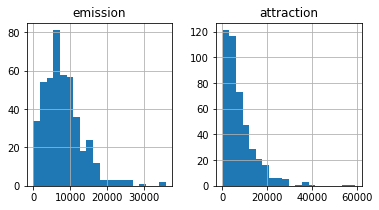

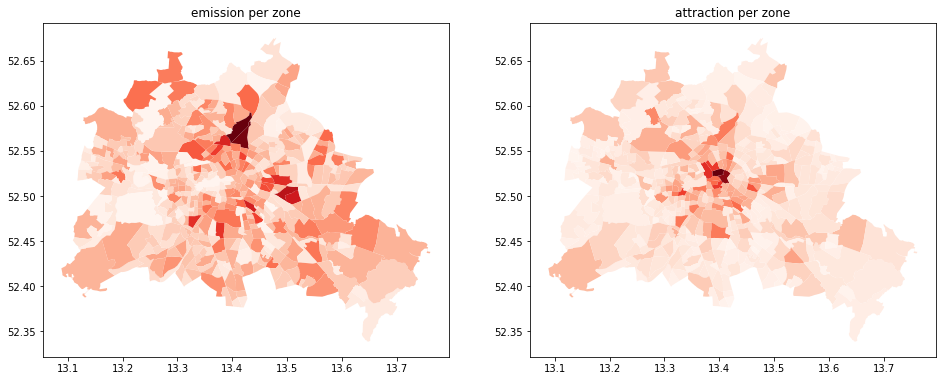

In [6]:
sm.zones[['emission', 'attraction']].hist(bins=20, figsize=(6,3))
fig, ax = plt.subplots(1, 2, figsize=(16,16))
sm.zones.plot(ax=ax.flat[0], column='emission', cmap="Reds")
ax.flat[0].set_title("emission per zone")
sm.zones.plot(ax=ax.flat[1], column='attraction', cmap="Reds")
ax.flat[1].set_title("attraction per zone")


In [7]:
# Now we need to introduce our demand segments.
# Car owners and PT captives is a good start.
# Other common demand segments are trip purposes, income groups, age groups.
sm.segments = ['car_owner', 'pt_captive']
car_ownership = 0.4 # To-Do: replace with demographic data
sm.zones[('car_owner', 'emission')] = sm.zones['emission'] * car_ownership
sm.zones[('pt_captive', 'emission')] = sm.zones['emission'] * (1-car_ownership)
sm.zones[('car_owner', 'attraction')] = sm.zones['attraction'] * car_ownership
sm.zones[('pt_captive', 'attraction')] = sm.zones['attraction'] * (1-car_ownership)

# Cast columns to integer
sm.zones[('car_owner', 'emission')] = sm.zones[('car_owner', 'emission')].astype(int)
sm.zones[('car_owner', 'attraction')] = sm.zones[('car_owner', 'attraction')].astype(int)
sm.zones[('pt_captive', 'emission')] = sm.zones[('pt_captive', 'emission')].astype(int)
sm.zones[('pt_captive', 'attraction')] = sm.zones[('pt_captive', 'attraction')].astype(int)

In [8]:
# Delete the non-segmented columns to prevent errors
del sm.zones['emission']
del sm.zones['attraction']
# sm.zones.sample()

## Step distribution

Once we have emission and attraction, we want to know the volumes per OD-pair. We can use the `step_distribution` function from quetzal. It uses the doubly constrained distribution (no probabilistic Logit approach), which is an iterative process where emissions and attractions are matched so that, on average, the minimal resistance for the whole system is found. Talking about resistance: an important input parameter is the impedance matrix, giving resistances between every OD-pair. Resistance can be time, but also cost or other utility/disutility quantifications.

Calibration of this step (not performed in this toy model) requires to change emission and attraction values or the impedance matrix

To-Do:
- check for distance travelled per inhabitant (compare to survey data)
- do we have transport data on district level or so?
- plot graphs for OD Matrix
- FRATAR algorithm, do we use it? Do we have to understand it?
- number is too small in relation to trips outside of zone. what has to be done?
- sometimes zones still have an above average connection to another zone even if its on the other side of the city. Whats the reason? What should be done?
- maybe stadtaubahn is treated as too slow in relation to other routes?

In [9]:
sm.car_los.head()

origin    destination        time  \
index                                             
0      zone_01011101  zone_01011101    0.000000   
1      zone_01011101  zone_01011102  479.500690   
2      zone_01011101  zone_01011103  321.042307   
3      zone_01011101  zone_01011104  345.000475   
4      zone_01011101  zone_01011105  293.205177   

                                                    path  \
index                                                      
0                                        [zone_01011101]   
1      [zone_01011101, 26874394, 26745299, 26874397, ...   
2      [zone_01011101, 26704698, 26704700, 26704702, ...   
3      [zone_01011101, 26704698, 26704700, 26704702, ...   
4      [zone_01011101, 26874394, 26745299, 26874397, ...   

                                               node_path  \
index                                                      
0                                                     []   
1      [26874394, 26745299, 26874397, 26703656, 26703...   
2      [26704698, 26704700, 26704702, 103553865, 2682...   
3      [26704698, 26704700, 26704702, 103553865, 2682...   
4      [26874394, 26745299, 26874397, 26703656, 26703...   

                                               link_path  \
index                                                      
0                                                     []   
1      [7686, 4937, 7690, 2681, 2675, 2678, 69015, 69...   
2      [2987, 2994, 2995, 38010, 6654, 38012, 6657, 6...   
3      [2987, 2994, 2995, 38010, 6654, 38012, 6657, 6...   
4      [7686, 4937, 7690, 2681, 2676, 120519, 75470, ...   

                                                  ntlegs    length  \
index                                                                
0                                                     []     0.000   
1      [[zone_01011101, 26874394], [1437259263, zone_...  1163.927   
2      [[zone_01011101, 26704698], [388310225, zone_0...  1449.637   
3      [[zone_01011101, 26704698], [26765676, zone_01...  1677.885   
4      [[zone_01011101, 26874394], [162070841, zone_0...  1724.303   

      route_types route_type     price  
index                                   
0           [car]        car  0.000000  
1           [car]        car  0.139671  
2           [car]        car  0.173956  
3           [car]        car  0.201346  
4           [car]        car  0.206916

In [10]:
# Now, we need an impedance matrix for car and PT, respectively.
# Use time as resistance value, but distance or cost are thinkable, too
car_imp_matrix = sm.car_los[['origin', 'destination', 'time']].set_index(
    ['origin','destination']).unstack()
# Assign a resistance for staying in the home cell
car_imp_matrix = car_imp_matrix.replace(0, 120)
car_imp_matrix.head(3)

time                                            \
destination   zone_01011101 zone_01011102 zone_01011103 zone_01011104   
origin                                                                  
zone_01011101    120.000000     479.50069    321.042307    345.000475   
zone_01011102    495.732531     120.00000    557.482804    581.440972   
zone_01011103    327.772654     547.64098    120.000000    221.410924   

                                                                       \
destination   zone_01011105 zone_01011201 zone_01011202 zone_01011203   
origin                                                                  
zone_01011101    293.205177    368.865421    460.989784    449.957274   
zone_01011102    508.490247    584.150490    618.125841    618.108995   
zone_01011103    238.847942    344.012346    436.136709    425.104199   

                                           ...                              \
destination   zone_01011204 zone_01011301  ... zone_12301205 zone_12301206   
origin                                     ...                               
zone_01011101    511.401578    461.919823  ...   1147.695717   1295.649504   
zone_01011102    717.606139    590.212009  ...   1302.406399   1437.372557   
zone_01011103    458.656039    459.044183  ...   1231.314675   1379.268462   

                                                                       \
destination   zone_12302107 zone_12302108 zone_12302109 zone_12302110   
origin                                                                  
zone_01011101    983.458393   1319.499162   1282.807957   1111.309007   
zone_01011102   1138.169075   1474.209844   1424.531010   1266.019689   
zone_01011103   1067.077350   1403.118120   1366.426914   1194.927964   

                                                                       
destination   zone_12302211 zone_12302212 zone_12304313 zone_12304314  
origin                                                                 
zone_01011101   1090.649464   1130.802245    969.821953   1030.201537  
zone_01011102   1245.360146   1285.512927   1138.553141   1198.932724  
zone_01011103   1174.268422   1214.421202   1067.461416   1127.841000  

[3 rows x 448 columns]

In [11]:
# In the PT case we have to take the minimum time per OD pair,
# because we have multiple routes
pt_imp_matrix = sm.pt_los.groupby(
    ['origin', 'destination']).agg({'time': 'min'}).unstack()

pt_imp_matrix = pt_imp_matrix.replace(0, 120)
pt_imp_matrix.head(3)

time                                            \
destination   zone_01011101 zone_01011102 zone_01011103 zone_01011104   
origin                                                                  
zone_01011101    120.000000    782.482052    779.980010   1245.950698   
zone_01011102    782.482052    120.000000    835.858288    951.465842   
zone_01011103    779.980010    835.858288    120.000000    824.827720   

                                                                       \
destination   zone_01011105 zone_01011201 zone_01011202 zone_01011203   
origin                                                                  
zone_01011101   1100.867594   1228.593702    1228.69580   1390.194404   
zone_01011102    806.382738   1170.769312    1170.87141   1332.370014   
zone_01011103    687.284738   1210.227829    1306.75521   1389.753814   

                                           ...                              \
destination   zone_01011204 zone_01011301  ... zone_12301205 zone_12301206   
origin                                     ...                               
zone_01011101   1553.230589   1401.036441  ...   3031.961186   3297.768366   
zone_01011102   1495.406199   1343.212051  ...   2974.136796   3107.080094   
zone_01011103   1547.141398   1537.084938  ...   3031.520596   3390.191794   

                                                                       \
destination   zone_12302107 zone_12302108 zone_12302109 zone_12302110   
origin                                                                  
zone_01011101   2738.466093   2758.930126   2869.160341   2654.066925   
zone_01011102   2547.777820   2568.241854   2678.472068   2463.378652   
zone_01011103   2830.889520   2851.353554   2961.583768   2746.490352   

                                                                       
destination   zone_12302211 zone_12302212 zone_12304313 zone_12304314  
origin                                                                 
zone_01011101   2752.642549   2963.017194   2571.453465   2754.718879  
zone_01011102   2610.454277   2820.828922   2380.765193   2564.030607  
zone_01011103   2845.065977   3055.440622   2663.876893   2847.142307  

[3 rows x 448 columns]

In [12]:
# We can perform the quetzal distribution function for all
# our demand segments simultaniously, saving us post-processing.
# Therefore, we need a dictionary with all parameters
distr_params = {'deterrence_matrix': {'car_owner': car_imp_matrix,
                                      'pt_captive': pt_imp_matrix}}
sm.step_distribution(segmented=True, **distr_params)

sm.volumes.head(3)

car_owner
pt_captive


origin    destination  car_owner  pt_captive       all
0  zone_01011101  zone_01011101   0.672170    0.339839  1.012010
1  zone_01011101  zone_01011102   1.149141    1.167845  2.316986
2  zone_01011101  zone_01011103   2.965744    3.625005  6.590749

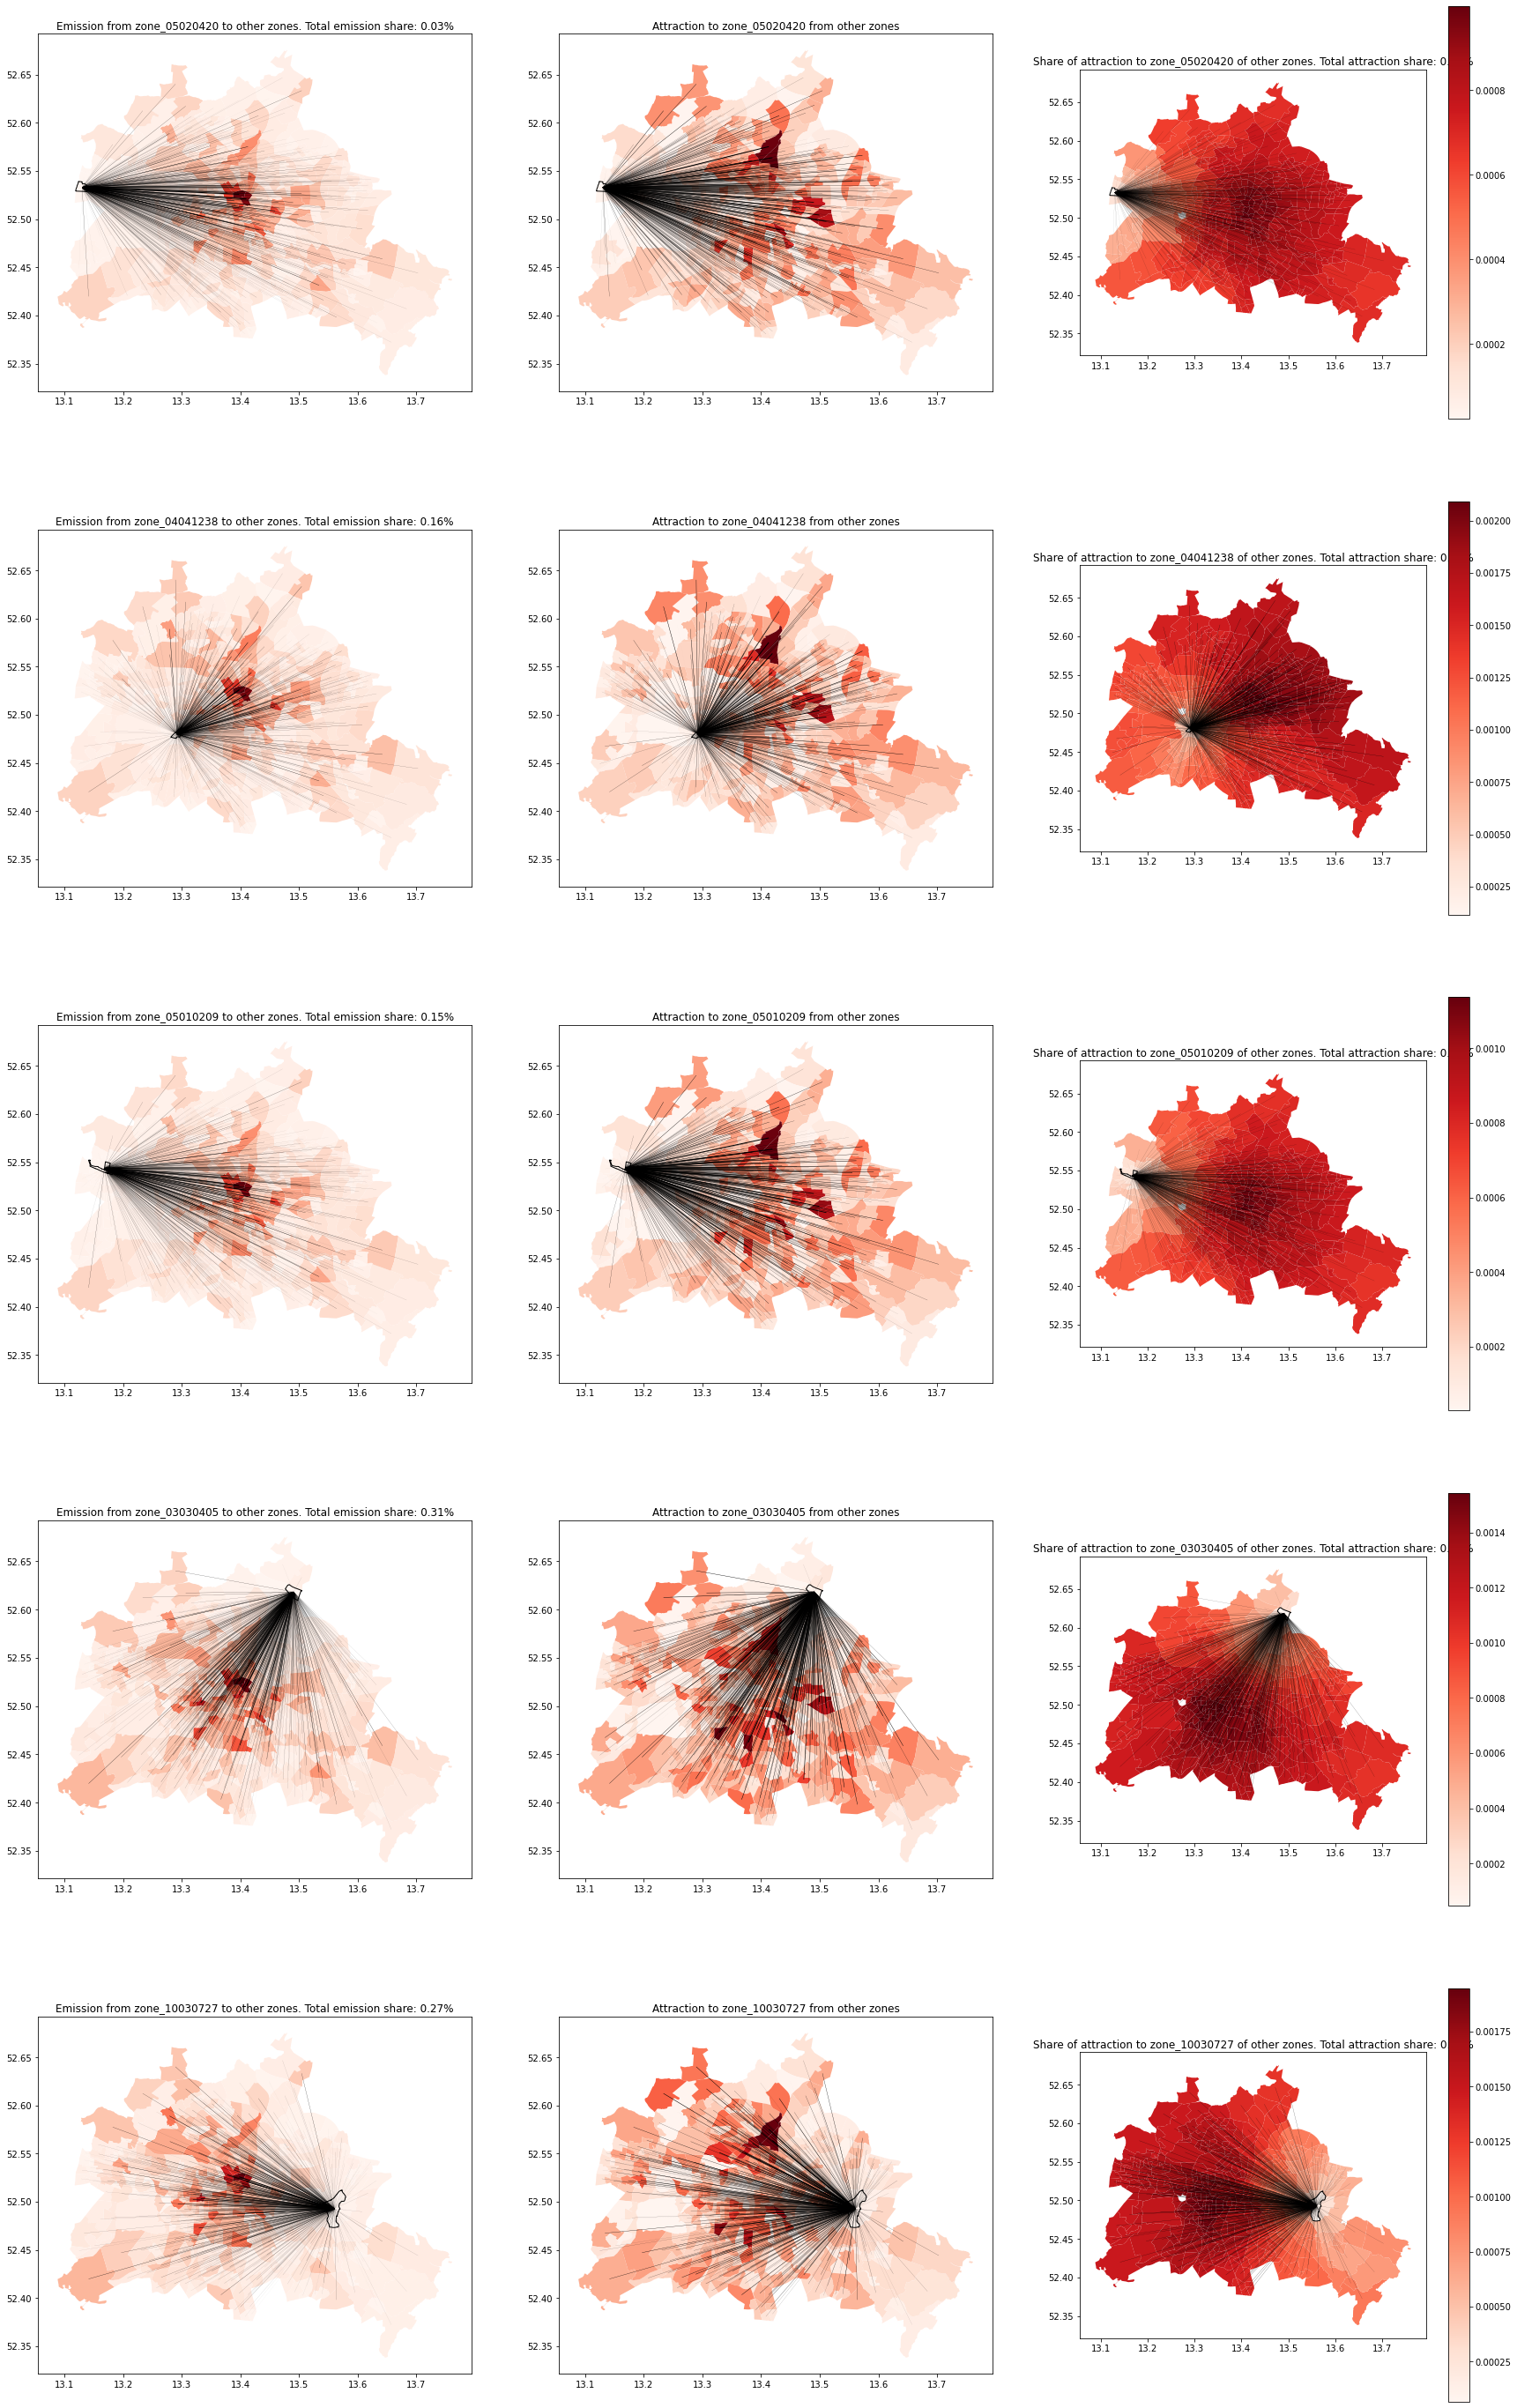

In [13]:
if show_plots:
    N = 5
    fig, ax = plt.subplots(nrows=N, ncols=3, figsize=(30,10*N))
    for (n, ind) in enumerate(np.random.permutation(len(sm.zones))[:N]):
        z_id = sm.zones.index[ind]
        
        z_emission = sm.volumes[['destination', 'all']][sm.volumes['origin']==z_id]
        z_attraction = sm.volumes[['origin', 'all']][sm.volumes['destination']==z_id]
        z_emission_from = np.array([item for sublist in [z_emission['all'][z_emission['destination']==i] for i in sm.zones.index] for item in sublist])
        z_attraction_to = np.array([item for sublist in [z_attraction['all'][z_attraction['origin']==i] for i in sm.zones.index] for item in sublist])

        all_emissions = np.array([sum(sm.volumes['all'][sm.volumes['origin']==i]) for i in sm.zones.index])
        all_attractions = np.array([sum(sm.volumes['all'][sm.volumes['destination']==i]) for i in sm.zones.index])
        # z_attraction_share = np.array([sm.volumes['all'][(sm.volumes['origin']==i) & (sm.volumes['destination']==z_id)].iloc[0]/sum(sm.volumes['all'][sm.volumes['origin']==i]) for i in sm.zones.index])
        z_attraction_share = np.array([sm.volumes['all'][(sm.volumes['origin']==i) & (sm.volumes['destination']==z_id)].iloc[0]/e for i,e in zip(sm.zones.index, all_emissions)])


        sm.zones.plot(ax=ax.flat[n*3], cmap="Reds", \
            column=z_emission_from)
        sm.zones.plot(ax=ax.flat[n*3+1], cmap="Reds", \
            column=z_attraction_to)
        sm.zones.plot(ax=ax.flat[n*3+2], cmap="Reds", \
            column=z_attraction_share, legend=True)
        

        z_centroid_coords = sm.zones['geometry'].loc[z_id].centroid.coords[0]
        lines = sm.zones.geometry.apply(lambda g: LineString([z_centroid_coords, g.centroid.centroid.coords[0]]))
        
        lines.plot(ax=ax.flat[n*3], color="black", linewidth=z_emission_from/z_emission_from.max())
        lines.plot(ax=ax.flat[n*3+1], color="black", linewidth=z_attraction_to/z_attraction_to.max())
        lines.plot(ax=ax.flat[n*3+2], color="black", linewidth=z_attraction_share/(all_attractions.max()/sum(all_attractions))*2)
        
        
        sm.zones[sm.zones.index==z_id].plot(ax=ax.flat[n*3], color="None", edgecolor='black', linewidth=1)
        sm.zones[sm.zones.index==z_id].plot(ax=ax.flat[n*3+1], color="None", edgecolor='black', linewidth=1)
        sm.zones[sm.zones.index==z_id].plot(ax=ax.flat[n*3+2], color="None", edgecolor='black', linewidth=1)

        ax.flat[n*3].set_title('Emission from '+ str(z_id) + ' to other zones. Total emission share: ' + str(round(100*z_emission_from.sum()/sum(all_attractions),2)) +'%')
        ax.flat[n*3+1].set_title('Attraction to '+ str(z_id) + ' from other zones')
        ax.flat[n*3+2].set_title('Share of attraction to '+ str(z_id) + ' of other zones. Total attraction share: ' + str(round(100*z_attraction_to.sum()/sum(all_emissions),2))+'%')


## Step mode choice

For mode choice we apply a nested logit model. In modeling terms, this step can be understood as the "logit" step, because the resulting utilities could also be used to compute the impedance matrix from above. You will see, that the logit step is entirely independent of the volumes and could, thus, be done earlier.

In [14]:
# First, we need parameters for our logit model.
# We define the nesting structure (i.e. choice tree)
# and the beta parameters which should come from a calibration
# using a mobility survey.
sm.preparation_logit(time=-0.00055, # beta_t
                     price=-1, # beta_p
                     transfers=0, # we don't want the number of transfers matter (even though it does sometimes)
                     mode=1, # theta_root
                     pt_mode=0.5, # theta_pt (nest parameter for PT)
                     pt_path=0.1, # theta_path (nest parameter for different paths of one PT option)
                     segments=sm.segments
)
# For nest parameters you should take 1 >= mode >= pt_mode >= pt_path > 0

In [15]:
# Now we have generated the nesting structure table
# Can differ by demand segment, if you want
sm.mode_nests

segment     root car_owner pt_captive
route_type                           
walk        root      root       root
root         NaN       NaN        NaN
car         root      root       root
tram          pt        pt         pt
bus           pt        pt         pt
rail          pt        pt         pt
subway        pt        pt         pt
pt          root      root       root

In [16]:
# And the corresponding theta values
sm.logit_scales

segment     root  car_owner  pt_captive
route_type                             
walk         0.0        0.0         0.0
root         1.0        1.0         1.0
car          0.0        0.0         0.0
tram         0.1        0.1         0.1
bus          0.1        0.1         0.1
rail         0.1        0.1         0.1
subway       0.1        0.1         0.1
pt           0.5        0.5         0.5

In [17]:
# And the Alternative-Specific-Constants (ASC)
# We have to prevent PT captives from using a car
sm.mode_utility.loc[ 'car', 'pt_captive'] = -100
sm.mode_utility

segment     root  car_owner  pt_captive
route_type                             
walk           0          0           0
root           0          0           0
car            0          0        -100
tram           0          0           0
bus            0          0           0
rail           0          0           0
subway         0          0           0

In [18]:
# And the beta parameters
# The column 'mode_utility' refers to the weight of the ASC table
# Delete the transfers attribute because we don't want it in our model formulation
sm.utility_values.drop('ntransfers', inplace=True)
sm.utility_values

segment          root  car_owner  pt_captive
value                                       
time         -0.00055   -0.00055    -0.00055
price        -1.00000   -1.00000    -1.00000
mode_utility  1.00000    1.00000     1.00000

In [19]:
# Now, add segment specific ASC column to LoS table.
# But first we have to generate a combined LoS table
sm.los = pd.concat([sm.pt_los, sm.car_los]).reset_index(drop=True)
sm.los['route_types'] = sm.los['route_types'].apply(tuple)# bugfix
sm.analysis_mode_utility(how='main', # how refers to how to calculate the ASC from multiple paths
                         segment=None) # automatically iterates through segments

100%|██████████| 2/2 [00:00<00:00,  4.13it/s]


In [20]:
# Finally, run the logit model
sm.initialize_logit()
# If you want to know what parameters you can give to the function,
# look into the code. You can find the most important functions in
# the quetzal/model/transportmodel.py file, which refers to sub-functions
# by importing them from other quetzal files
sm.step_logit()

100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


In [21]:
# The result is a utilities table
sm.utilities.head(3)

route_type         origin    destination     segment      root         car  \
0           zone_01022101  zone_01011101   car_owner -0.680080   -0.700721   
1           zone_01022101  zone_01011101  pt_captive -4.570854 -100.700721   
2           zone_01022101  zone_01011102   car_owner -0.701833   -0.725428   

route_type  walk        pt  subway  rail       bus  tram  
0           -inf -4.570854    -inf  -inf -4.570854  -inf  
1           -inf -4.570854    -inf  -inf -4.570854  -inf  
2           -inf -4.460345    -inf  -inf -4.460345  -inf

In [22]:
# and the probabilities
sm.probabilities.head(3)

route_type         origin    destination     segment  root           car  \
0           zone_01022101  zone_01011101   car_owner     1  9.795705e-01   
1           zone_01022101  zone_01011101  pt_captive     1  1.783729e-42   
2           zone_01022101  zone_01011102   car_owner     1  9.766816e-01   

route_type  walk        pt  subway  rail       bus  tram  
0            0.0  0.020430     0.0   0.0  0.020430   0.0  
1            0.0  1.000000     0.0   0.0  1.000000   0.0  
2            0.0  0.023318     0.0   0.0  0.023318   0.0

In [23]:
# Moreover, you have now probabilities assigned to your paths!
sm.los.head(3)

origin    destination       gtime  \
0  zone_01011101  zone_01011101    0.000000   
1  zone_01011101  zone_01011102  782.482052   
2  zone_01011101  zone_01011103  779.980010   

                                    path pathfinder_session reversed  \
0                        [zone_01011101]          best_path    False   
1  [zone_01011101, n_448, zone_01011102]          best_path    False   
2  [zone_01011101, n_201, zone_01011103]          best_path    False   

  boardings alightings node_path link_path  ... access_length footpath_length  \
0        []         []        []        []  ...      0.000000             0.0   
1        []         []   [n_448]        []  ...   1068.787885             0.0   
2        []         []   [n_201]        []  ...   1071.025877             0.0   

  in_vehicle_length       length price mode_utility  (car_owner, utility)  \
0               0.0     0.000000  3.75            0             -3.750000   
1               0.0  1068.787885  3.75            0             -4.180365   
2               0.0  1071.025877  3.75            0             -4.178989   

   (pt_captive, utility)  (car_owner, probability) (pt_captive, probability)  
0              -3.750000                  0.022977                       1.0  
1              -4.180365                  0.022380                       1.0  
2              -4.178989                  0.021280                       1.0  

[3 rows x 37 columns]

## Step assignment

This step combines the path probabilities with the volumes and loads them onto the networks.

In [24]:
sm.volumes.head(2)

origin    destination  car_owner  pt_captive       all
0  zone_01011101  zone_01011101   0.672170    0.339839  1.012010
1  zone_01011101  zone_01011102   1.149141    1.167845  2.316986

In [25]:
# We want to do an assignment for cars and PT seperately
# (although there is a wrapper function in quetzal)
# Therefore, we must transfer the path probabilities to pt_los and car_los
sm.car_los = sm.los.loc[sm.los['route_type']=='car']
sm.pt_los = sm.los.loc[sm.los['route_type']!='car']

In [26]:
# PT first
sm.segmented_pt_assignment(split_by='route_type', # identify from which route type the load comes
                           on_road_links=False, # load bus traffic to the road network (requires casted networks)
                           path_column='link_path' # pt_los column with the path list
                          )

pt_captive: 100%|██████████| 2/2 [00:11<00:00,  5.84s/it]


In [27]:
# Now cars
sm.segmented_car_assignment()

pt_captive: 100%|██████████| 2/2 [01:00<00:00, 30.45s/it]


In [28]:
sm.loaded_links.loc[sm.loaded_links['load']!=0].sample()

trip_id      a      b  link_sequence  time  headway  \
index                                                               
link_702  10224_109_0  n_408  n_178              2  72.0      600   

           pattern_id   route_id service_id  direction_id  ... origin  \
index                                                      ...          
link_702  10224_109_0  10224_109       1591             0  ...  n_408   

         destination                                           geometry  \
index                                                                     
link_702       n_178  LINESTRING (13.34989 52.48121, 13.34273 52.47715)   

         road_node_list road_link_list (load, bus) (load, subway)  \
index                                                               
link_702             []             []         0.0            0.0   

          (load, rail)  (load, tram)         load  
index                                              
link_702   1141.308821           0.0  1141.308821  

[1 rows x 31 columns]

In [29]:
sm.road_links.loc[sm.road_links[('all', 'car')]!=0].sample()

a         b   length  avspeed      time  walk_time  \
index                                                              
91446  30432646  30432643  321.521     30.0  38.58252    964.563   

                                                geometry    highway maxspeed  \
index                                                                          
91446  LINESTRING (13.37351 52.59456, 13.37549 52.59718)  secondary       30   

       (car_owner, car)  (pt_captive, car)   (all, car)  
index                                                    
91446       2421.159165       8.186773e-39  2421.159165

<AxesSubplot:>

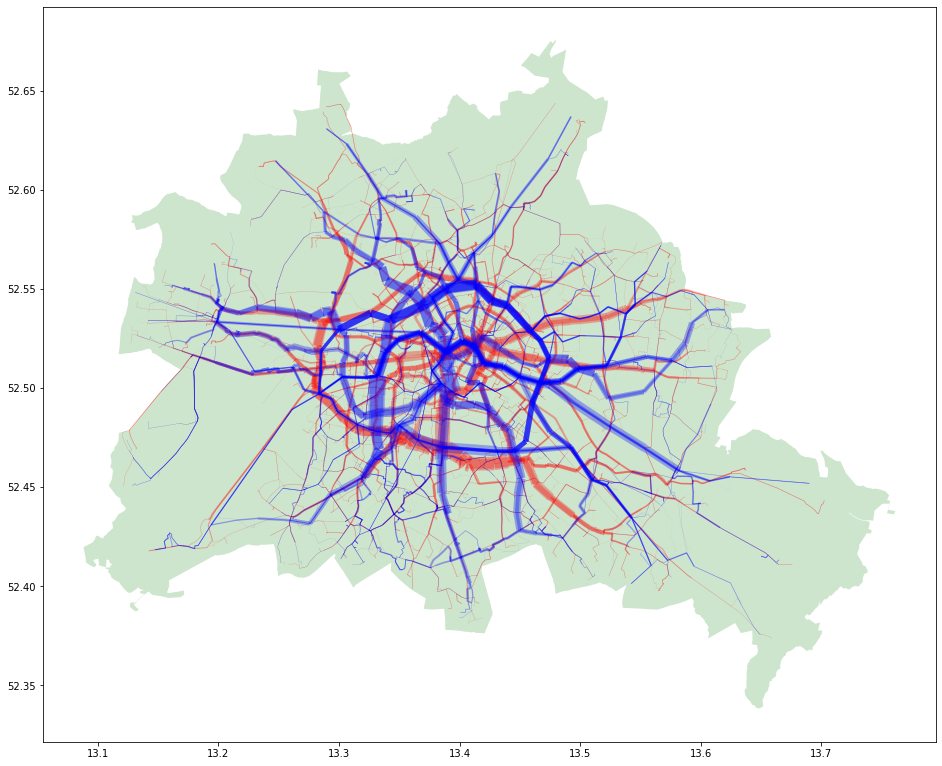

In [30]:
sm.loaded_links = gpd.GeoDataFrame(sm.loaded_links, crs=sm.epsg)
sm.road_links = gpd.GeoDataFrame(sm.road_links, crs=sm.epsg)
scaler = max(sm.loaded_links['load'].max(), sm.road_links[('all', 'car')].max()) / (35/2)

fig, ax = plt.subplots(figsize = (16,16))
sm.zones.plot(ax=ax, alpha=.2, color='green')
sm.road_links.plot(ax=ax, alpha=.3, color='red', linewidth=list(sm.road_links[('all', 'car')]/scaler))
sm.loaded_links.plot(ax=ax, alpha=.3, color='blue', linewidth=list(sm.loaded_links['load']/scaler))

# sm.loaded_links.plot(alpha=.3, color='blue', linewidth=list(sm.loaded_links['load']/scaler),
#     ax=sm.road_links.plot(alpha=.3, color='red', linewidth=list(sm.road_links[('all', 'car')]/scaler),
#         ax=sm.plot('zones', alpha=.2, color='green', figsize=(16,16))))

## Read in validation data
To-Do:
- Maybe the addition of validation data can be moved to an earlier step in the process (Maybe directly after network creation)

link_id               elem_nr         vnp         nnp  vst  \
9198  51480004_51480005  51480004_51480005.01  51480004.0  51480005.0  0.0   

        bst vricht  ebene str_typ strklasse1 strklasse strklasse2  \
9198  111.0      B    0.0       S        III         G       STRA   

                 str_name    bezirk stadtteil  dtvw_kfz  dtvw_lkw  \
9198  Neuköllnische Allee  Neukölln  Neukölln    4800.0     260.0   

                                               geometry  
9198  LINESTRING (13.47279 52.46120, 13.47303 52.461...

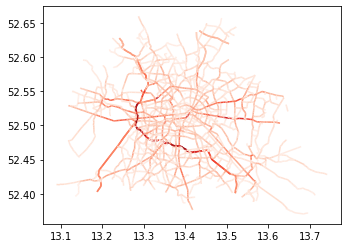

In [31]:
traffic_validation = gpd.read_file(input_path + "validation/Verkehrsmengen.shp")
traffic_validation.to_crs(epsg=4326, inplace=True)
traffic_validation.plot(cmap="Reds", column='dtvw_kfz')
traffic_validation.sample(1)


In [93]:
sm.road_links.head()

a           b   length  avspeed       time  walk_time  \
index                                                               
1      172539    34694265  237.653     50.0  17.111016    712.959   
2      172539    34694336  687.484     50.0  49.498848   2062.452   
3      172539  3977742457  391.153     50.0  28.163016   1173.459   
4      172545   271370539   17.179     50.0   1.236888     51.537   
5      172545    28345515  171.849     50.0  12.373128    515.547   

                                                geometry    highway maxspeed  \
index                                                                          
1      LINESTRING (13.33550 52.56521, 13.33859 52.56428)   tertiary       50   
2      LINESTRING (13.33550 52.56521, 13.34515 52.56680)  secondary       50   
3      LINESTRING (13.33550 52.56521, 13.33114 52.56289)  secondary       50   
4      LINESTRING (13.34661 52.56703, 13.34664 52.56688)   tertiary       50   
5      LINESTRING (13.34661 52.56703, 13.34681 52.56857)   tertiary       50   

       (car_owner, car)  (pt_captive, car)  (all, car)  validation_load  \
index                                                                     
1                   NaN                NaN         0.0     10916.934116   
2                   NaN                NaN         0.0     13832.674960   
3                   NaN                NaN         0.0     19240.840810   
4                   NaN                NaN         0.0     12033.495869   
5                   NaN                NaN         0.0      9612.426825   

       validation_threshold  
index                        
1                     False  
2                     False  
3                      True  
4                     False  
5                      True

Text(0.5, 1.0, 'traffic load on roads based on model ouput')

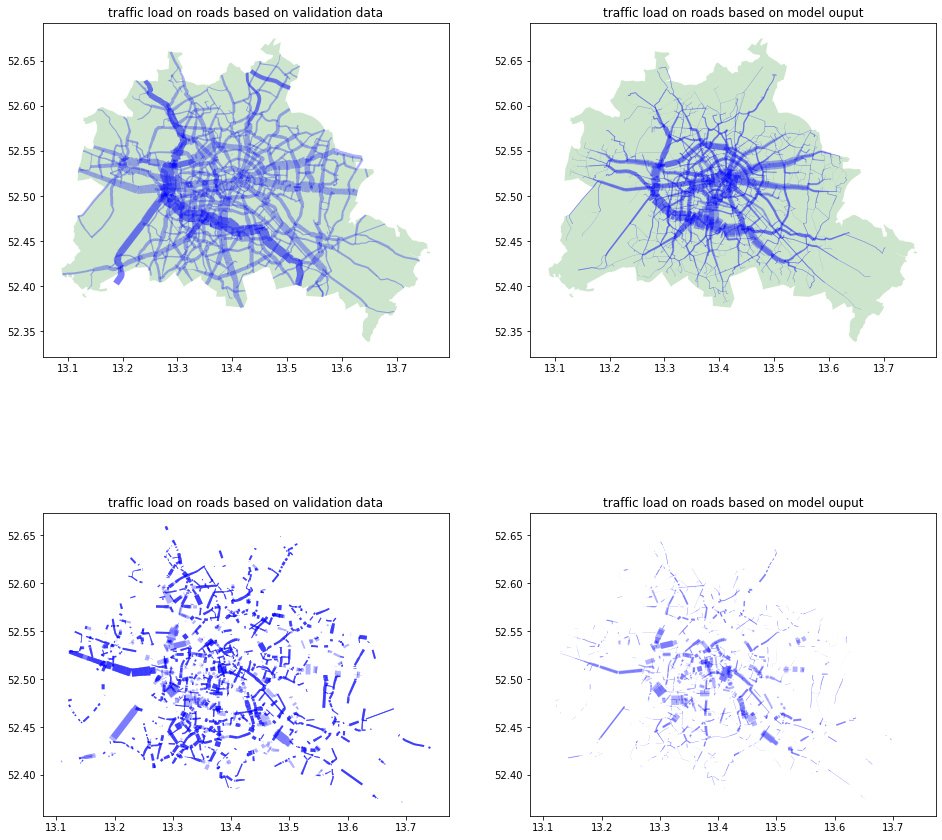

In [99]:
if show_plots:
    scaler_v = traffic_validation['dtvw_kfz'].max() / (35)


    fig, ax = plt.subplots(ncols=2, nrows=2, figsize = (16,16))
    sm.zones.plot(ax=ax.flat[0], alpha=.2, color='green')
    sm.zones.plot(ax=ax.flat[1], alpha=.2, color='green')
    traffic_validation.plot(ax=ax.flat[0], alpha=.3, color="blue", linewidth=list(traffic_validation['dtvw_kfz']/(scaler)))
    sm.road_links.plot(ax=ax.flat[1], alpha=.3, color='blue', linewidth=list(sm.road_links[('all', 'car')]/scaler))

    sm.road_links[sm.road_links['validation_threshold']].plot(ax=ax.flat[2], alpha=.3, color='blue', linewidth=list(sm.road_links['validation_load'][sm.road_links['validation_threshold']]/scaler))
    sm.road_links[sm.road_links['validation_threshold']].plot(ax=ax.flat[3], alpha=.3, color='blue', linewidth=list(sm.road_links[('all', 'car')][sm.road_links['validation_threshold']]/scaler))
    ax.flat[0].set_title('traffic load on roads based on validation data')
    ax.flat[1].set_title('traffic load on roads based on model ouput')
    ax.flat[2].set_title('traffic load on roads based on validation data')
    ax.flat[3].set_title('traffic load on roads based on model ouput')


## Match validation data to road network
- logic: create buffers around road_network and obtain intersection between the network polygons to match road links from validation data to road links from network
- for an even more accurate matching one could use the non-simplified links.

#### Validation data and sm.road_links

network: 43158802.92397995 validation: 219503778.1968649 ratio n/v: 0.197


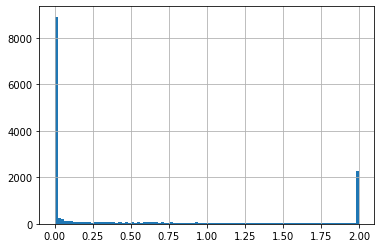

In [38]:
total_load_network = sum(sm.road_links[('all', 'car')][sm.road_links['validation_threshold']])
total_load_validation = sum(sm.road_links['validation_load'][sm.road_links['validation_threshold']])
print('network:', total_load_network, 
    'validation:',  total_load_validation, 'ratio n/v:', round(total_load_network/total_load_validation,3))

r_gdf = GeoDataFrame({
    'ratio': total_load_validation/total_load_network * sm.road_links[('all', 'car')][sm.road_links['validation_threshold']] / sm.road_links['validation_load'][sm.road_links['validation_threshold']]
    }, geometry=sm.road_links['geometry'][sm.road_links['validation_threshold']], crs=sm.epsg)

# ax0 = r_gdf['ratio'].hist(bins=100)
r_gdf['ratio_cut']=[x if x<2 else 2 for x in r_gdf['ratio']]
ax1 = r_gdf['ratio_cut'].hist(bins=100)


In [60]:

# what can be a validation parameter?
# maybe correlation of shares

load_network = sm.road_links[('all', 'car')][sm.road_links['validation_threshold']] #sum()
load_validation = sm.road_links['validation_load'][sm.road_links['validation_threshold']] #sum()

load_share_network = load_network/load_network.sum()
load_share_validation = load_validation/load_validation.sum()

corr = np.corrcoef(load_share_network, load_share_validation)[0,1]
print(corr)

0.3411493146011291


In [67]:
load_network.sum(), load_validation.sum(), load_network.sum()/ load_validation.sum()

(43158802.92397988, 219503778.1968651, 0.19661986357825825)

Text(0.5, 1.0, 'Blue: Model predicts less traffic than validation data, Red: model predicts to much traffic')

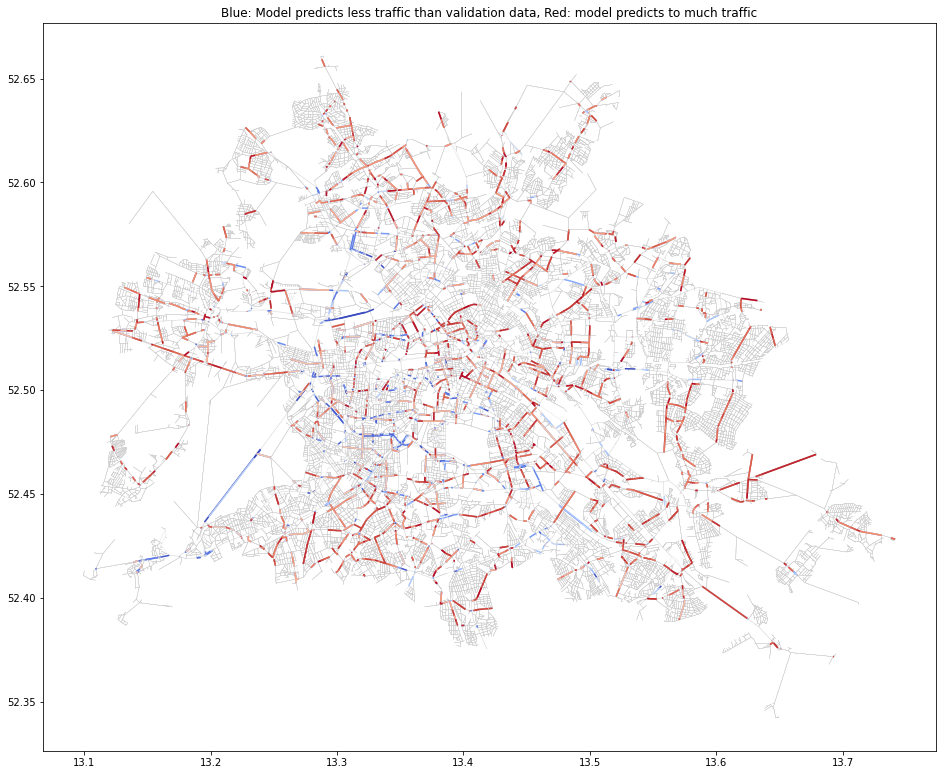

In [68]:
fig, ax = plt.subplots(figsize = (16,16))
sm.road_links.plot(ax=ax, color="#cccccc", linewidth=0.25)
r_gdf.plot(ax=ax, cmap='coolwarm', legend=True)
ax.set_title("Blue: Model predicts less traffic than validation data, Red: model predicts to much traffic")

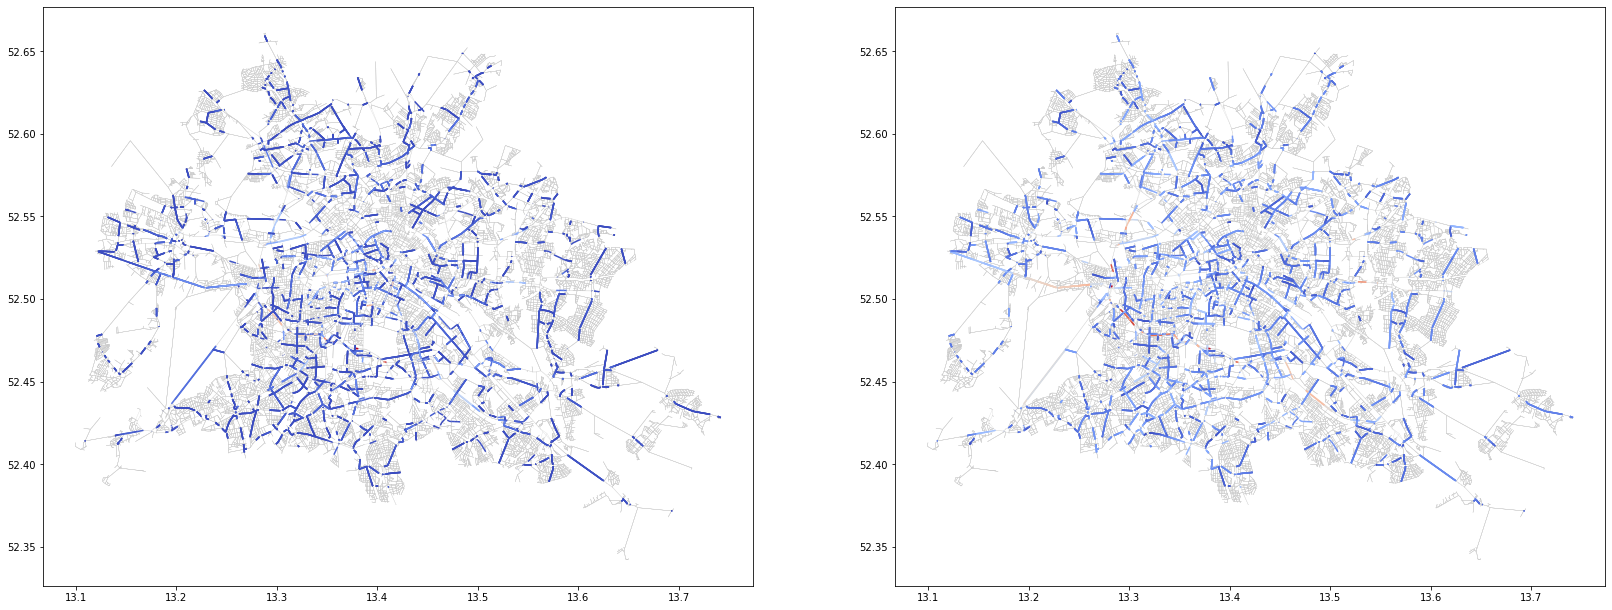

In [84]:
if show_plots:
    fig, ax = plt.subplots(ncols=2, figsize = (28,16))
    sm.road_links.plot(ax=ax.flat[0], color="#cccccc", linewidth=0.25)
    sm.road_links.plot(ax=ax.flat[1], color="#cccccc", linewidth=0.25)
    col0 = np.array([x for x in sm.road_links[('all', 'car')][(sm.road_links['validation_threshold'])&(sm.road_links['validation_load']>500)]])
    col1 = np.array([x for x in sm.road_links['validation_load'][(sm.road_links['validation_threshold'])&(sm.road_links['validation_load']>500)]])
    sm.road_links[(sm.road_links['validation_threshold'])&(sm.road_links['validation_load']>500)].plot(ax=ax.flat[0], column=col0, cmap='coolwarm')#, legend=True
    sm.road_links[(sm.road_links['validation_threshold'])&(sm.road_links['validation_load']>500)].plot(ax=ax.flat[1], column=col1, cmap='coolwarm')#, legend=True

#### Validation data and sm.loaded_links

In [45]:
total_load_network_l = sum(sm.loaded_links['load'][sm.loaded_links['validation_threshold']])
total_load_validation = sum(sm.loaded_links['validation_load'][sm.loaded_links['validation_threshold']])
print('network:', total_load_network_l, 
    'validation:',  total_load_validation, 'ratio n/v:', round(total_load_network_l/total_load_validation,3))

network: 1864489.5702775118 validation: 20532590.826672085 ratio n/v: 0.091


## Model Results

In [46]:
# Summary of LoS table using a quetzal function
# All attributes are multiplied with path probabilities
od_sum = sm.summary_od(costs=['price', # EUR per person
                              'time', # seconds per ride
                              'in_vehicle_time', # seconds per ride
                              'length', # Meter distance
                              'ntransfers']) # per ride

In [47]:
# Compute passenger kilometer
for seg in sm.segments + ['root']:
    od_sum[(seg, 'pkm')] = od_sum[(seg, 'volume')] * od_sum[(seg, 'length')] / 1000
    # Adjust units of other indicators
    od_sum[(seg, 'in_vehicle_time')] = od_sum[(seg, 'in_vehicle_time')] / 3600
    od_sum[(seg, 'time')] = od_sum[(seg, 'time')] / 3600
    od_sum[(seg, 'length')] = od_sum[(seg, 'length')] / 1000

In [48]:
od_sum.sample(3)

segment                            car_owner                      \
sum                                   volume     price      time   
origin        destination   mode                                   
zone_05040936 zone_08041035 subway  0.216889  0.285336  0.085395   
zone_05010205 zone_09020601 rail    0.257403  0.470749  0.109169   
zone_04041343 zone_01033203 rail    0.094738  0.063443  0.006925   

segment                                                                  \
sum                                in_vehicle_time    length ntransfers   
origin        destination   mode                                          
zone_05040936 zone_08041035 subway        0.060396  2.669741   0.057067   
zone_05010205 zone_09020601 rail          0.048330  4.367112   0.094150   
zone_04041343 zone_01033203 rail          0.003151  0.221280   0.000000   

segment                            pt_captive                                  \
sum                                    volume price      time in_vehicle_time   
origin        destination   mode                                                
zone_05040936 zone_08041035 subway   6.165922   5.0  1.496399        1.058333   
zone_05010205 zone_09020601 rail     4.536690   5.0  1.159528        0.513333   
zone_04041343 zone_01033203 rail    10.247609   5.0  0.545782        0.248333   

segment                             ...                  root            \
sum                                 ... ntransfers     volume     price   
origin        destination   mode    ...                                   
zone_05040936 zone_08041035 subway  ...        1.0   6.382812  4.839795   
zone_05010205 zone_09020601 rail    ...        1.0   4.794093  4.756817   
zone_04041343 zone_01033203 rail    ...        0.0  10.342347  4.954780   

segment                                                                  \
sum                                     time in_vehicle_time     length   
origin        destination   mode                                          
zone_05040936 zone_08041035 subway  1.448453        1.024423  45.283468   
zone_05010205 zone_09020601 rail    1.103132        0.488367  44.128721   
zone_04041343 zone_01033203 rail    0.540846        0.246087  17.281472   

segment                                       car_owner  pt_captive  \
sum                                ntransfers       pkm         pkm   
origin        destination   mode                                      
zone_05040936 zone_08041035 subway   0.967959  0.579038  288.456802   
zone_05010205 zone_09020601 rail     0.951363  1.124107  210.433087   
zone_04041343 zone_01033203 rail     0.000000  0.020964  178.710025   

segment                                   root  
sum                                        pkm  
origin        destination   mode                
zone_05040936 zone_08041035 subway  289.035839  
zone_05010205 zone_09020601 rail    211.557193  
zone_04041343 zone_01033203 rail    178.730989  

[3 rows x 21 columns]

array([<AxesSubplot:ylabel='(car_owner, volume)'>,
       <AxesSubplot:ylabel='(pt_captive, volume)'>], dtype=object)

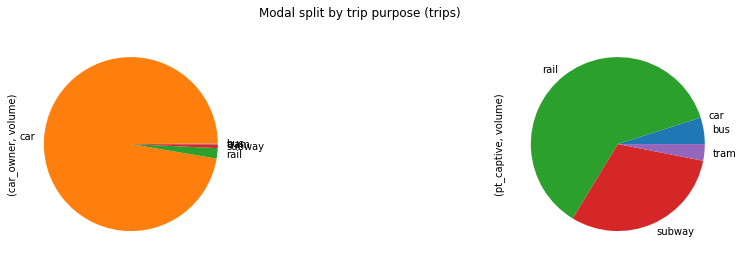

In [49]:
od_sum.loc[:, [(seg, 'volume') for seg in sm.segments]].groupby(level=2).sum().plot.pie(
    subplots=True, figsize=(16, 4), legend=False, title='Modal split by trip purpose (trips)')

array([<AxesSubplot:ylabel='(car_owner, pkm)'>,
       <AxesSubplot:ylabel='(pt_captive, pkm)'>], dtype=object)

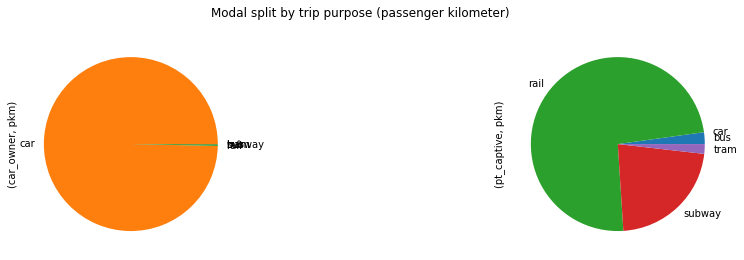

In [50]:
od_sum.loc[:, [(seg, 'pkm') for seg in sm.segments]].groupby(level=2).sum().plot.pie(
    subplots=True, figsize=(16, 4), legend=False, title='Modal split by trip purpose (passenger kilometer)')

## Save model

In [51]:
# Save the od_sum as Excel
if not os.path.exists('../../outputs/'):
    os.makedirs('../../outputs/')
with pd.ExcelWriter('../../outputs/od_summary.xlsx') as writer:  
    od_sum.to_excel(writer, sheet_name='od_sum')

KeyboardInterrupt: 

In [52]:
# make sure that all tables have unique indicies before saving
sm.probabilities.reset_index(inplace=True, drop=True)
sm.utilities.reset_index(inplace=True, drop=True)

In [53]:
sm.to_json(model_path + 'four_steps')

to_hdf(overwriting):  60%|██████    | 27/45 [01:53<00:28,  1.61s/it]

could not save geometry from table fare_rules
could not save geometry from table fare_attributes


to_hdf(overwriting): 100%|██████████| 45/45 [03:18<00:00,  4.42s/it]

could not save attribute: parameters
